In [10]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from quantum_base import Net as Net_orig
from quantum_base_kerr import Net as Net_kerr
from data import generate_synthetic_dataset_easy
from Plotting.Plot import BasicPlot, MultiPlot
tf.compat.v1.enable_eager_execution()
import pandas as pd
import seaborn as sns
from CalculateFisherInformation import Calculate_Fisher_Information_Matrix
from sklearn.model_selection import ParameterGrid
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

tf.random.set_seed(None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Second Method
Taken from https://github.com/amyami187/effective_dimension/blob/v1.0.0/effective_dimension/classical_nn.py

In [22]:
params_quantum = {
    'network_type': ['quantum'],
    'n_layers': [1, 2],
    'num_qumodes': [2],
    'cutoff': [3, 7, 11],
    'n_inputs': [20, 100],
    'n_iter': [10, 100],
}

params_classical = {
    'network_type': ['classical'],
    'n_layers': [1, 2, 3, 4, 5],
    'num_qumodes': [1, 2, 3, 4],
    'n_inputs': [20, 50, 100],
    'n_iter': [10, 50, 100],
}

param_grid_quantum = ParameterGrid(params_quantum)
param_grid_classical = ParameterGrid(params_classical)

for params in param_grid_classical:
    model = Net_kerr(network_type=params['network_type'],
                     num_qumodes=params['num_qumodes'],
                     n_layers=params['n_layers'],
                     cutoff=1,
                     max_initial_weight=0.2)
    x_train = np.random.uniform(0, 1, size=[params['n_inputs'], 2*params['num_qumodes']])
    fisher_obj = Calculate_Fisher_Information_Matrix(
        x_train=x_train,
        model_func=lambda : copy.deepcopy(model),
        n_iter=params['n_iter'],
    )
    
    fhat = fisher_obj.get_fhat()
    f_trace = fisher_obj.get_fisher_trace()
    np.save(f'./fisher_information/data/{params["network_type"]}_n_layers={params["n_layers"]}_num_qumodes={params["num_qumodes"]}_n_inputs={params["n_inputs"]}_n_iter={params["n_iter"]}.npy', fhat)
    np.save(f'./fisher_information/data/{params["network_type"]}_n_layers={params["n_layers"]}_num_qumodes={params["num_qumodes"]}_n_inputs={params["n_inputs"]}_n_iter={params["n_iter"]}_trace.npy', f_trace)
    
for params in param_grid_quantum:
    model = Net_kerr(network_type=params['network_type'],
                     num_qumodes=params['num_qumodes'],
                     n_layers=params['n_layers'],
                     cutoff=params['cutoff'],)
    
    x_train = np.random.uniform(0, 1, size=[params['n_inputs'], 2*params['num_qumodes']])
    fisher_obj = Calculate_Fisher_Information_Matrix(
        x_train=x_train,
        model_func=lambda : copy.deepcopy(model),
        n_iter=params['n_iter'],
    )
    
    fhat = fisher_obj.get_fhat()
    f_trace = fisher_obj.get_fisher_trace()
    np.save(f'./fisher_information/data/{params["network_type"]}_n_layers={params["n_layers"]}_num_qumodes={params["num_qumodes"]}_cutoff={params["cutoff"]}_n_inputs={params["n_inputs"]}_n_iter={params["n_iter"]}_fhat.npy', fhat)
    np.save(f'./fisher_information/data/{params["network_type"]}_n_layers={params["n_layers"]}_num_qumodes={params["num_qumodes"]}_cutoff={params["cutoff"]}_n_inputs={params["n_inputs"]}_n_iter={params["n_iter"]}_trace.npy', f_trace)
    
# model_func = lambda : Net_kerr(
#     network_type='quantum',
#     n_layers=1,
#     num_qumodes=2,
#     cutoff=3,
#     max_initial_weight=0.2
# )

# paper_initializer = keras.initializers.RandomUniform(minval=0, maxval=1)

# # model_func = lambda : keras.models.Sequential([
# #         keras.layers.Dense(4, activation='leaky_relu', kernel_initializer=paper_initializer, use_bias=False),
# #         keras.layers.Dense(4, activation='leaky_relu', kernel_initializer=paper_initializer, use_bias=False),
# #         keras.layers.Dense(2, activation='tanh', kernel_initializer=paper_initializer, use_bias=False),
# #         keras.layers.Softmax()
# #     ])

# x_train = np.random.uniform(0, 1, size=[20, 2])

# model = model_func()
# model(x_train[0:1])

# fisher_obj = Calculate_Fisher_Information_Matrix(
#     model_func=model_func,
#     x_train=x_train,
#     n_iter=10,
# )

# fhat = fisher_obj.get_fhat()
# fhat_eigvals = []

# for i in range(fhat.shape[0]):
#     fhat_eigvals.append(np.linalg.eigvals(fhat[i]).real)
# fhat_eigvals = np.mean(np.array(fhat_eigvals), axis=0)
# print(fhat_eigvals.shape)

Calculating Fishers: 100%|██████████| 10000/10000 [00:50<00:00, 197.79it/s]


Max Initial Amplitudes: 0.22445000000000076


Calculating Fishers: 100%|██████████| 200/200 [00:00<00:00, 511.56it/s]


Max Initial Amplitudes: 0.14070000000000096


Calculating Fishers: 100%|██████████| 200/200 [00:00<00:00, 501.77it/s]


Max Initial Amplitudes: 0.22780000000000075


Calculating Fishers: 100%|██████████| 2000/2000 [00:03<00:00, 664.61it/s]


Max Initial Amplitudes: 0.14070000000000096


Calculating Fishers: 100%|██████████| 2000/2000 [00:03<00:00, 635.10it/s]


Max Initial Amplitudes: 0.22445000000000076


Calculating Fishers: 100%|██████████| 1000/1000 [00:01<00:00, 665.31it/s]


Max Initial Amplitudes: 0.14070000000000096


Calculating Fishers: 100%|██████████| 1000/1000 [00:01<00:00, 598.23it/s]


Max Initial Amplitudes: 0.22780000000000075


Calculating Gradients:  55%|█████▌    | 55/100 [4:12:14<3:26:22, 275.17s/it]


KeyboardInterrupt: 

Mean: 0.7071067811865472, Max: 14.142323242985961, Min: -4.120724089209682e-17, STD: 3.0822048198451597


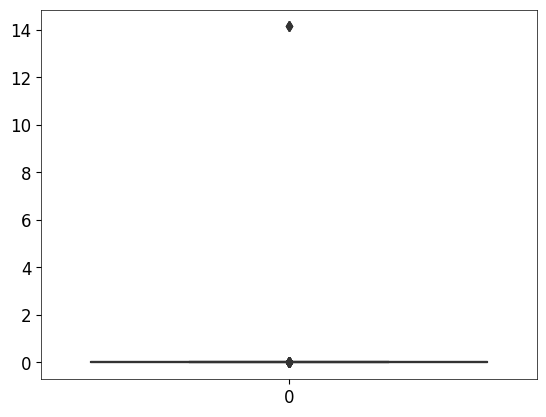

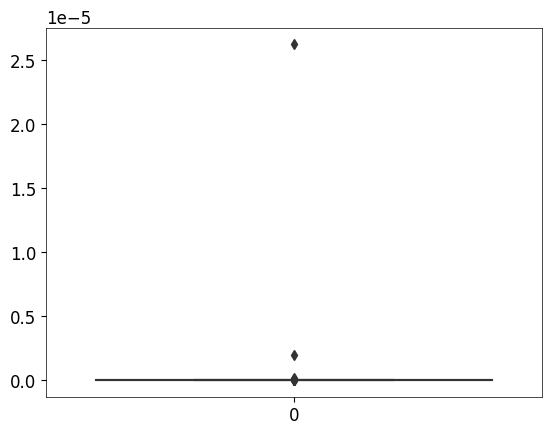

0.95


In [8]:
print(f'Mean: {np.mean(fhat_eigvals)}, Max: {np.max(fhat_eigvals)}, Min: {np.min(fhat_eigvals)}, STD: {np.std(fhat_eigvals)}')
sns.boxplot(fhat_eigvals)
plt.show()
sns.boxplot(fhat_eigvals[fhat_eigvals < 1])
plt.show()
print(len(fhat_eigvals[fhat_eigvals < 1])/len(fhat_eigvals))